In [162]:
import os,warnings,sys,time,re,math
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["KERAS_BACKEND"] = "tensorflow"
from IPython.display import clear_output,HTML
warnings.filterwarnings("ignore")
from glob import glob
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import hvplot as hv
hv.extension("plotly")
import dask.dataframe as dd
from dask.distributed import Client
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
tf.get_logger().setLevel("ERROR")
%matplotlib inline
clear_output()

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

# Overview

- Polars is entirely based on Arrow dat types and backed by Arrow memory arrays. This makes data processing cache-efficient and well -supported for Inter Process Communication . Most data types follow the exact implementation from Arrow, with the excpetio of ```String``` (thisis actually ```LargeUtf8```), ```Categorical``` , and ```Object``` (support is limited). The data types are:

## Numeric - Int8,Int16,Int32,Int64,UInt8,UInt16,UInt32,UInt64,Float32,Float64
## Nested - Struct,List
## Temporal - Date,Datetime,Duration,Time
## Other - Boolean,String,Binary,Object,Categorical,Enum

# Floating Point

- Polars generally follows IEEE 756 with some exceptions as:
  - Any NaN compares equal to any other NaN, and is greater than any-other Non-NaN value
  - Operations do not guarentee any particular behavior on the sign of zero or NaN. This is not just limited to arthmetic operations, e.g. a sort or group by operation may canonicalize all zeros to +0 and all NaNs to postive NaN without payload for efficient equality checks

In [4]:
train_files = glob("Downloads/credit_risk/train/*")
test_files = glob("Downloads/credit_risk/test/*")
print(f"Number of Train files: {len(train_files)}")
print(f"Number of Test files: {len(test_files)}")

Number of Train files: 32
Number of Test files: 36


In [5]:
train_base = pl.read_parquet(train_files[7])
train_base.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


In [6]:
train_base.glimpse()

Rows: 1526659
Columns: 5
$ case_id       <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ date_decision <str> '2019-01-03', '2019-01-03', '2019-01-04', '2019-01-03', '2019-01-04', '2019-01-02', '2019-01-03', '2019-01-03', '2019-01-03', '2019-01-03'
$ MONTH         <i64> 201901, 201901, 201901, 201901, 201901, 201901, 201901, 201901, 201901, 201901
$ WEEK_NUM      <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ target        <i64> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0



In [7]:
train_base.select(
    [
        pl.col("case_id"),
        pl.col("WEEK_NUM"),
        pl.col("target")
    ]
).head()

case_id,WEEK_NUM,target
i64,i64,i64
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


In [8]:
(
    train_base
    .group_by(["WEEK_NUM"])
    .agg(
        pl.col("target").count().alias("target_counts")
    )
).head()

WEEK_NUM,target_counts
i64,u32
9,14716
12,17105
15,17713
18,11729
6,16385


In [9]:
train_base.schema

OrderedDict([('case_id', Int64),
             ('date_decision', String),
             ('MONTH', Int64),
             ('WEEK_NUM', Int64),
             ('target', Int64)])

In [10]:
train_base.dtypes

[Int64, String, Int64, Int64, Int64]

In [11]:
train_base["WEEK_NUM"].dtype

Int64

In [12]:
train_base["WEEK_NUM"].to_frame().head()

WEEK_NUM
i64
0
0
0
0
0


In [13]:
values = [_**2 for _ in range(100)]

In [14]:
pl.Series(values).head()

""
i64
0
1
4
9
16
25
36
49
64


In [15]:
data_dict = {"col0":[2,3,4],"col1":[5,6,7]}
pl.DataFrame(data_dict)

col0,col1
i64,i64
2,5
3,6
4,7


In [16]:
temp_df = pl.DataFrame(data_dict,schema=dict(col0=pl.Int32,col1=pl.Int32))
temp_df

col0,col1
i32,i32
2,5
3,6
4,7


In [17]:
temp_df.to_dicts()

[{'col0': 2, 'col1': 5}, {'col0': 3, 'col1': 6}, {'col0': 4, 'col1': 7}]

In [18]:
pl.show_versions()

--------Version info---------
Polars:               0.20.8
Index type:           UInt32
Platform:             Linux-5.15.0-94-generic-x86_64-with-glibc2.31
Python:               3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]

----Optional dependencies----
adbc_driver_manager:  0.9.0
cloudpickle:          2.2.1
connectorx:           0.3.2
deltalake:            0.15.3
fsspec:               2023.12.2
gevent:               24.2.1
hvplot:               0.9.2
matplotlib:           3.8.2
numpy:                1.26.3
openpyxl:             3.0.10
pandas:               2.2.0
pyarrow:              15.0.0
pydantic:             2.6.1
pyiceberg:            0.5.1
pyxlsb:               <not installed>
sqlalchemy:           2.0.25
xlsx2csv:             0.8.2
xlsxwriter:           3.1.9


In [19]:
train_base.to_numpy()

array([[0, '2019-01-03', 201901, 0, 0],
       [1, '2019-01-03', 201901, 0, 0],
       [2, '2019-01-04', 201901, 0, 0],
       ...,
       [2703452, '2020-10-05', 202010, 91, 0],
       [2703453, '2020-10-05', 202010, 91, 0],
       [2703454, '2020-10-05', 202010, 91, 0]], dtype=object)

In [20]:
train_base.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


In [21]:
ints_array = (
    train_base
    .select(
        pl.col(pl.Int64)
    )
    .to_numpy()
)
ints_array

array([[      0,  201901,       0,       0],
       [      1,  201901,       0,       0],
       [      2,  201901,       0,       0],
       ...,
       [2703452,  202010,      91,       0],
       [2703453,  202010,      91,       0],
       [2703454,  202010,      91,       0]])

In [22]:
temp_df = pl.DataFrame(np.random.randint(low=0,high=20,size=(4,4)),schema=dict(column_1=pl.Int32,column_2=pl.Int32,column_3=pl.Int32,column_0=pl.Int32))
temp_df

column_1,column_2,column_3,column_0
i32,i32,i32,i32
7,8,4,8
9,1,14,16
6,1,6,18
4,7,12,3


In [23]:
temp_pdf = pd.DataFrame(np.random.randint(low=0,high=20,size=(4,4)),columns=["column_0","column_1","column_2","column3"])
temp_pdf

,column_0,column_1,column_2,column3
0,12,0,7,9
1,7,17,14,14
2,14,7,7,2
3,9,8,1,15


In [24]:
train_base.to_pandas().dtypes

case_id           int64
date_decision    object
MONTH             int64
WEEK_NUM          int64
target            int64
dtype: object

In [25]:
train_base.to_pandas(use_pyarrow_extension_array=True).dtypes

case_id                 int64[pyarrow]
date_decision    large_string[pyarrow]
MONTH                   int64[pyarrow]
WEEK_NUM                int64[pyarrow]
target                  int64[pyarrow]
dtype: object

# Filetring Rows

In [26]:
train_base[:2]

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0


In [27]:
train_base[[0]]

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0


In [28]:
train_base[[-1]]

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
2703454,"""2020-10-05""",202010,91,0


In [29]:
(
    train_base
    .filter(
        pl.col("case_id") > 1000000
    )
    .select("case_id","WEEK_NUM","target")
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
1000001,80,0
1000002,80,0
1000003,80,1
1000004,80,0
1000005,80,0


## Keyword filter

- only works with equality operator

In [30]:
(
    train_base
    .filter(
        case_id = 1000002
    )
    .select("case_id","WEEK_NUM","target")
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
1000002,80,0


## Filtering on a boolean list

In [31]:
boolean_list = [True if target == 1 else False for target in train_base["target"]]
(
    train_base
    .filter(
        boolean_list
    )
    .select("case_id","WEEK_NUM","target")
).head()

case_id,WEEK_NUM,target
i64,i64,i64
4,0,1
101,0,1
118,0,1
129,0,1
148,0,1


In [32]:
(
    train_base
    .with_columns(
        target_defaulted = pl.col("target") > 0
    )
    .filter(
        pl.col("target_defaulted")
    )
    .select("case_id","WEEK_NUM","target")
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
4,0,1
101,0,1
118,0,1
129,0,1
148,0,1


In [33]:
target_class_dict = (
    train_base
    .partition_by("target",as_dict=True)
)

In [34]:
target_class_dict.keys()

dict_keys([0, 1])

In [35]:
(
    target_class_dict[1]
    .head()
)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
4,"""2019-01-04""",201901,0,1
101,"""2019-01-03""",201901,0,1
118,"""2019-01-03""",201901,0,1
129,"""2019-01-04""",201901,0,1
148,"""2019-01-04""",201901,0,1


In [36]:
week_num_dict = (
    train_base
    .partition_by("WEEK_NUM",as_dict=True)
)
week_num_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91])

In [37]:
(
    week_num_dict[2]
    .head()
)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
716,"""2019-01-17""",201901,2,0
762,"""2019-01-17""",201901,2,0
809,"""2019-01-17""",201901,2,0
901,"""2019-01-18""",201901,2,0
916,"""2019-01-16""",201901,2,0


In [38]:
(
    pl.scan_parquet(train_files[7])
    .head()
).columns

['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']

In [39]:
(
    pl.scan_parquet(train_files[7])
    .filter(
        pl.col("target") > 0
    )
    .select("case_id","WEEK_NUM","target")
    .fetch()
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
4,0,1
101,0,1
118,0,1
129,0,1
148,0,1


In [40]:
train_lazy = pl.scan_parquet(train_files[7]).filter(pl.col("target") > 0)
print(train_lazy)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

FILTER [(col("target")) > (0)] FROM

  Parquet SCAN Downloads/credit_risk/train/train_base.parquet
  PROJECT */5 COLUMNS


In [41]:
print(train_lazy.explain())


  Parquet SCAN Downloads/credit_risk/train/train_base.parquet
  PROJECT */5 COLUMNS
  SELECTION: [(col("target")) > (0)]


In [42]:
train_lazy = (
    pl.scan_parquet(train_files[7])
    .filter(
        pl.col("target") > 0
    )
    .filter(
        pl.col("WEEK_NUM") > 15
    )
)
print(train_lazy)
print("*--------------------------------------------------------------------------------*")
print(train_lazy.explain())

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

FILTER [(col("WEEK_NUM")) > (15)] FROM
FILTER [(col("target")) > (0)] FROM

  Parquet SCAN Downloads/credit_risk/train/train_base.parquet
  PROJECT */5 COLUMNS
*--------------------------------------------------------------------------------*

  Parquet SCAN Downloads/credit_risk/train/train_base.parquet
  PROJECT */5 COLUMNS
  SELECTION: [([(col("WEEK_NUM")) > (15)]) & ([(col("target")) > (0)])]


In [43]:
train_base[10,"MONTH"]

201901

In [44]:
train_base[15:20,"MONTH"]

MONTH
i64
201901
201901
201901
201901
201901


In [45]:
train_base[15:20,:3]

case_id,date_decision,MONTH
i64,str,i64
15,"""2019-01-03""",201901
16,"""2019-01-03""",201901
17,"""2019-01-03""",201901
18,"""2019-01-03""",201901
19,"""2019-01-03""",201901


In [46]:
train_base[15:20,"case_id":"WEEK_NUM"]

case_id,date_decision,MONTH,WEEK_NUM
i64,str,i64,i64
15,"""2019-01-03""",201901,0
16,"""2019-01-03""",201901,0
17,"""2019-01-03""",201901,0
18,"""2019-01-03""",201901,0
19,"""2019-01-03""",201901,0


In [47]:
(
    train_base
    .select(pl.col("case_id"))
    .head()
)

case_id
i64
0
1
2
3
4


In [48]:
(
    train_base
    .select(["case_id","WEEK_NUM"])
    .head()
)

case_id,WEEK_NUM
i64,i64
0,0
1,0
2,0
3,0
4,0


In [49]:
(
    train_base
    .select(
        pl.col("MONTH")/100 * pl.col("target")
    )
    .head()
)

MONTH
f64
0.0
0.0
0.0
0.0
2019.01


In [50]:
(
    train_base
    .select(
        [
            pl.col("MONTH"),
            pl.col("MONTH").cast(pl.String).alias("MONTH_STRING")
        ]
    ).head()
)

MONTH,MONTH_STRING
i64,str
201901,"""201901"""
201901,"""201901"""
201901,"""201901"""
201901,"""201901"""
201901,"""201901"""


In [51]:
print(
    (
        (
            pl.scan_parquet(train_files[7])
        )
        .select(["case_id","WEEK_NUM","target"])
        .with_columns(
            pl.col("target").cast(pl.Float32)
        )
    )
    .explain()
)

 WITH_COLUMNS:
 [col("target").strict_cast(Float32)]
  FAST_PROJECT: [case_id, WEEK_NUM, target]

      Parquet SCAN Downloads/credit_risk/train/train_base.parquet
      PROJECT 3/5 COLUMNS


In [52]:
(
    pl.read_parquet(train_files[7])
    .select(
        cs.all()
    )
    .head()
)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


In [53]:
(
    pl.read_parquet(train_files[7])
    .select(
        pl.exclude(["date_decision","MONTH"])
    )
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


In [54]:
(
    pl.read_parquet(train_files[7])
    .select(
        pl.col(pl.INTEGER_DTYPES)
    )
    .head()
)

case_id,MONTH,WEEK_NUM,target
i64,i64,i64,i64
0,201901,0,0
1,201901,0,0
2,201901,0,0
3,201901,0,0
4,201901,0,1


In [55]:
(
    pl.read_parquet(train_files[7])
    .select(
        cs.contains("e") | cs.contains("N")
    )
    .head()
)

case_id,date_decision,target,MONTH,WEEK_NUM
i64,str,i64,i64,i64
0,"""2019-01-03""",0,201901,0
1,"""2019-01-03""",0,201901,0
2,"""2019-01-04""",0,201901,0
3,"""2019-01-03""",0,201901,0
4,"""2019-01-04""",1,201901,0


In [56]:
(
    pl.read_parquet(train_files[7])
    .select(
        cs.exclude(["MONTH","date_decision"])
    )
    .head()
)

case_id,WEEK_NUM,target
i64,i64,i64
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


In [57]:
temp_df = pl.read_parquet(train_files[7])
pl.concat(
    [
        temp_df.min(),
        temp_df.max()
    ]
)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-01""",201901,0,0
2703454,"""2020-10-05""",202010,91,1


In [58]:
temp_df.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM,target
str,f64,str,f64,f64,f64
"""count""",1.526659e6,"""1526659""",1.526659e6,1.526659e6,1.526659e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.2861e6,null,201936.287982,40.769036,0.031437
"""std""",718946.592285,null,44.735975,23.797981,0.174496
"""min""",0.0,"""2019-01-01""",201901.0,0.0,0.0
"""25%""",766198.0,null,201906.0,23.0,0.0
"""50%""",1.357358e6,null,201910.0,40.0,0.0
"""75%""",1.739023e6,null,202001.0,55.0,0.0
"""max""",2.703454e6,"""2020-10-05""",202010.0,91.0,1.0


In [59]:
(
    pl.read_parquet(train_files[7])
    .with_columns(
        pl.col("target").cast(pl.Float32).alias("Target"),
        (pl.col("WEEK_NUM") * 2).alias("double_week")
    )
    .drop("target")
    .head()
)

case_id,date_decision,MONTH,WEEK_NUM,Target,double_week
i64,str,i64,i64,f32,i64
0,"""2019-01-03""",201901,0,0.0,0
1,"""2019-01-03""",201901,0,0.0,0
2,"""2019-01-04""",201901,0,0.0,0
3,"""2019-01-03""",201901,0,0.0,0
4,"""2019-01-04""",201901,0,1.0,0


In [60]:
(
    pl.read_parquet(train_files[7])
    .with_columns(
        pl.lit(np.nan).cast(pl.Float32).alias("Nan_column")
    )
    .head()
)

case_id,date_decision,MONTH,WEEK_NUM,target,Nan_column
i64,str,i64,i64,i64,f32
0,"""2019-01-03""",201901,0,0,NaN
1,"""2019-01-03""",201901,0,0,NaN
2,"""2019-01-04""",201901,0,0,NaN
3,"""2019-01-03""",201901,0,0,NaN
4,"""2019-01-04""",201901,0,1,NaN


In [61]:
(
    pl.read_parquet(train_files[7])
    .select(
        pl.col("case_id"),
        pl.when(pl.col("target") == 1)
        .then(pl.col("target"))
        .otherwise(-1)
        .cast(pl.Float32)
        .alias("target_inversed"),
        pl.col("target")
        .cast(pl.Float32)
        .alias("target_normal")
    )
    .head()
)

case_id,target_inversed,target_normal
i64,f32,f32
0,-1.0,0.0
1,-1.0,0.0
2,-1.0,0.0
3,-1.0,0.0
4,1.0,1.0


In [62]:
pl.read_parquet(train_files[7]).select(pl.col("WEEK_NUM").gather([1,-1]))

WEEK_NUM
i64
0
91


In [63]:
(
    pl.read_parquet(train_files[7])
    .select(
        pl.col("case_id"),
        pl.when(
            (pl.col("WEEK_NUM") < 33) & (pl.col("target") < 1)
        )
        .then(1)
        .when(
            (pl.col("WEEK_NUM") > 33) & (pl.col("WEEK_NUM") <= 66) & (pl.col("target")  < 1)
        )
        .then(2)
        .when(
            (pl.col("WEEK_NUM") > 66) & (pl.col("target")  < 1)
        )
        .then(3)
        .otherwise(0)
        .alias("undefaulted_week_num_class"),
        pl.when(
            (pl.col("WEEK_NUM") < 33) & (pl.col("target") > 0)
        )
        .then(1)
        .when(
            (pl.col("WEEK_NUM") > 33) & (pl.col("WEEK_NUM") <= 66) & (pl.col("target")  > 0)
        )
        .then(2)
        .when(
            (pl.col("WEEK_NUM") > 66) & (pl.col("target")  > 0)
        )
        .then(3)
        .otherwise(0)
        .alias("defaulted_week_num_class"),
        pl.col("target").cast(pl.Boolean)
    )
    .head()
)

case_id,undefaulted_week_num_class,defaulted_week_num_class,target
i64,i32,i32,bool
0,1,0,false
1,1,0,false
2,1,0,false
3,1,0,false
4,0,1,true


# Practice Questions

In [72]:
# Question 1.1

df = pl.scan_csv("train.csv")
print(df)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)


  Csv SCAN train.csv
  PROJECT */14 COLUMNS


In [65]:
# Question 1.2

(
    df
    .columns
)

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [66]:
# Question 1.3

(
    df
    .schema
)

OrderedDict([('PassengerId', String),
             ('HomePlanet', String),
             ('CryoSleep', Boolean),
             ('Cabin', String),
             ('Destination', String),
             ('Age', Float64),
             ('VIP', Boolean),
             ('RoomService', Float64),
             ('FoodCourt', Float64),
             ('ShoppingMall', Float64),
             ('Spa', Float64),
             ('VRDeck', Float64),
             ('Name', String),
             ('Transported', Boolean)])

In [70]:
df = pl.read_csv("train.csv")
df = df.lazy()
print(df)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

DF ["PassengerId", "HomePlanet", "CryoSleep", "Cabin"]; PROJECT */14 COLUMNS; SELECTION: "None"


In [79]:
try:
    (
        pl.scan_csv("train.csv")
        .pivot(index="VIP",columns="HomePlanet",values="Age",aggregate_function="mean")
    )
except AttributeError:
    print("There is no pivot in lazy scans")
    display(
        pl.read_csv("train.csv")
        .pivot(index="VIP",columns="HomePlanet",values="Age",aggregate_function="mean")
    )

There is no pivot in lazy scans


VIP,Europa,Earth,Mars,null
bool,f64,f64,f64,f64
false,34.129184,26.122644,29.029758,28.413613
true,38.244275,null,35.564516,40.0
null,35.714286,23.90991,30.341463,34.333333


In [98]:
(
    pl.scan_csv("train.csv")
    .fetch(1000)
    .drop_nulls()
    .pivot(index="VIP",columns="HomePlanet",values="Age",aggregate_function="mean")
)

VIP,Europa,Earth,Mars
bool,f64,f64,f64
false,35.64497,25.559194,27.339506
true,40.555556,null,37.25


In [105]:
df = pl.scan_csv('train.csv')
print(
    df
    .fetch()
    .shape
)
(
    df
    .fetch()
    .columns
)

(500, 14)


['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [106]:
df_lazy = pl.scan_csv("train.csv")
df_eager = df_lazy.collect()
df_lazy = df_eager.lazy()

In [107]:
df_eager.width

14

In [108]:
df_eager.height

8693

In [109]:
df_eager.glimpse()

Rows: 8693
Columns: 14
$ PassengerId   <str> '0001_01', '0002_01', '0003_01', '0003_02', '0004_01', '0005_01', '0006_01', '0006_02', '0007_01', '0008_01'
$ HomePlanet    <str> 'Europa', 'Earth', 'Europa', 'Europa', 'Earth', 'Earth', 'Earth', 'Earth', 'Earth', 'Europa'
$ CryoSleep    <bool> False, False, False, False, False, False, False, True, False, True
$ Cabin         <str> 'B/0/P', 'F/0/S', 'A/0/S', 'A/0/S', 'F/1/S', 'F/0/P', 'F/2/S', 'G/0/S', 'F/3/S', 'B/1/P'
$ Destination   <str> 'TRAPPIST-1e', 'TRAPPIST-1e', 'TRAPPIST-1e', 'TRAPPIST-1e', 'TRAPPIST-1e', 'PSO J318.5-22', 'TRAPPIST-1e', 'TRAPPIST-1e', 'TRAPPIST-1e', '55 Cancri e'
$ Age           <f64> 39.0, 24.0, 58.0, 33.0, 16.0, 44.0, 26.0, 28.0, 35.0, 14.0
$ VIP          <bool> False, False, True, False, False, False, False, False, False, False
$ RoomService   <f64> 0.0, 109.0, 43.0, 0.0, 303.0, 0.0, 42.0, 0.0, 0.0, 0.0
$ FoodCourt     <f64> 0.0, 9.0, 3576.0, 1283.0, 70.0, 483.0, 1539.0, 0.0, 785.0, 0.0
$ ShoppingMall  <f64> 0.0

In [110]:
df_eager.schema

OrderedDict([('PassengerId', String),
             ('HomePlanet', String),
             ('CryoSleep', Boolean),
             ('Cabin', String),
             ('Destination', String),
             ('Age', Float64),
             ('VIP', Boolean),
             ('RoomService', Float64),
             ('FoodCourt', Float64),
             ('ShoppingMall', Float64),
             ('Spa', Float64),
             ('VRDeck', Float64),
             ('Name', String),
             ('Transported', Boolean)])

In [111]:
df_eager.dtypes

[String,
 String,
 Boolean,
 String,
 String,
 Float64,
 Boolean,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 String,
 Boolean]

In [112]:
df_eager["HomePlanet"].dtype

String

In [113]:
df_eager.to_arrow()

pyarrow.Table
PassengerId: large_string
HomePlanet: large_string
CryoSleep: bool
Cabin: large_string
Destination: large_string
Age: double
VIP: bool
RoomService: double
FoodCourt: double
ShoppingMall: double
Spa: double
VRDeck: double
Name: large_string
Transported: bool
----
PassengerId: [["0001_01","0002_01","0003_01","0003_02","0004_01",...,"9276_01","9278_01","9279_01","9280_01","9280_02"]]
HomePlanet: [["Europa","Earth","Europa","Europa","Earth",...,"Europa","Earth","Earth","Europa","Europa"]]
CryoSleep: [[false,false,false,false,false,...,false,true,false,false,false]]
Cabin: [["B/0/P","F/0/S","A/0/S","A/0/S","F/1/S",...,"A/98/P","G/1499/S","G/1500/S","E/608/S","E/608/S"]]
Destination: [["TRAPPIST-1e","TRAPPIST-1e","TRAPPIST-1e","TRAPPIST-1e","TRAPPIST-1e",...,"55 Cancri e","PSO J318.5-22","TRAPPIST-1e","55 Cancri e","TRAPPIST-1e"]]
Age: [[39,24,58,33,16,...,41,18,26,32,44]]
VIP: [[false,false,true,false,false,...,true,false,false,false,false]]
RoomService: [[0,109,43,0,303,...,0

In [116]:
(
    df_eager
    .rename(
        {"VIP":"Vip"}
    )
    .head()
)

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,Vip,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,str,bool
"""0001_01""","""Europa""",false,"""B/0/P""","""TRAPPIST-1e""",39.0,false,0.0,0.0,0.0,0.0,0.0,"""Maham Ofraccul…",false
"""0002_01""","""Earth""",false,"""F/0/S""","""TRAPPIST-1e""",24.0,false,109.0,9.0,25.0,549.0,44.0,"""Juanna Vines""",true
"""0003_01""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",58.0,true,43.0,3576.0,0.0,6715.0,49.0,"""Altark Susent""",false
"""0003_02""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",33.0,false,0.0,1283.0,371.0,3329.0,193.0,"""Solam Susent""",false
"""0004_01""","""Earth""",false,"""F/1/S""","""TRAPPIST-1e""",16.0,false,303.0,70.0,151.0,565.0,2.0,"""Willy Santanti…",true


In [121]:
df_clone = df_eager.clone()
df_clone.head()

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,str,bool
"""0001_01""","""Europa""",false,"""B/0/P""","""TRAPPIST-1e""",39.0,false,0.0,0.0,0.0,0.0,0.0,"""Maham Ofraccul…",false
"""0002_01""","""Earth""",false,"""F/0/S""","""TRAPPIST-1e""",24.0,false,109.0,9.0,25.0,549.0,44.0,"""Juanna Vines""",true
"""0003_01""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",58.0,true,43.0,3576.0,0.0,6715.0,49.0,"""Altark Susent""",false
"""0003_02""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",33.0,false,0.0,1283.0,371.0,3329.0,193.0,"""Solam Susent""",false
"""0004_01""","""Earth""",false,"""F/1/S""","""TRAPPIST-1e""",16.0,false,303.0,70.0,151.0,565.0,2.0,"""Willy Santanti…",true


In [122]:
temp_df = pl.DataFrame({'a':[0,1,2],'b':[0,1,2.0]})
temp_df.dtypes

[Int64, Float64]

In [149]:
# Creating a Series and transforming it to list
display(pl.Series("case_ids",np.arange(train_base[-1,"case_id"])).head(5))
pl.Series("case_ids",np.arange(train_base[-1,"case_id"])).to_list()[:5]

case_ids
i64
0
1
2
3
4


[0, 1, 2, 3, 4]

In [150]:
df_eager.head()

PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
str,str,bool,str,str,f64,bool,f64,f64,f64,f64,f64,str,bool
"""0001_01""","""Europa""",false,"""B/0/P""","""TRAPPIST-1e""",39.0,false,0.0,0.0,0.0,0.0,0.0,"""Maham Ofraccul…",false
"""0002_01""","""Earth""",false,"""F/0/S""","""TRAPPIST-1e""",24.0,false,109.0,9.0,25.0,549.0,44.0,"""Juanna Vines""",true
"""0003_01""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",58.0,true,43.0,3576.0,0.0,6715.0,49.0,"""Altark Susent""",false
"""0003_02""","""Europa""",false,"""A/0/S""","""TRAPPIST-1e""",33.0,false,0.0,1283.0,371.0,3329.0,193.0,"""Solam Susent""",false
"""0004_01""","""Earth""",false,"""F/1/S""","""TRAPPIST-1e""",16.0,false,303.0,70.0,151.0,565.0,2.0,"""Willy Santanti…",true


In [156]:
home_planet_counts = (
    df_eager["HomePlanet"]
    .drop_nulls()
    .value_counts()
    .sort("HomePlanet")
)
home_planet_counts

HomePlanet,count
str,u32
"""Earth""",4602
"""Europa""",2131
"""Mars""",1759


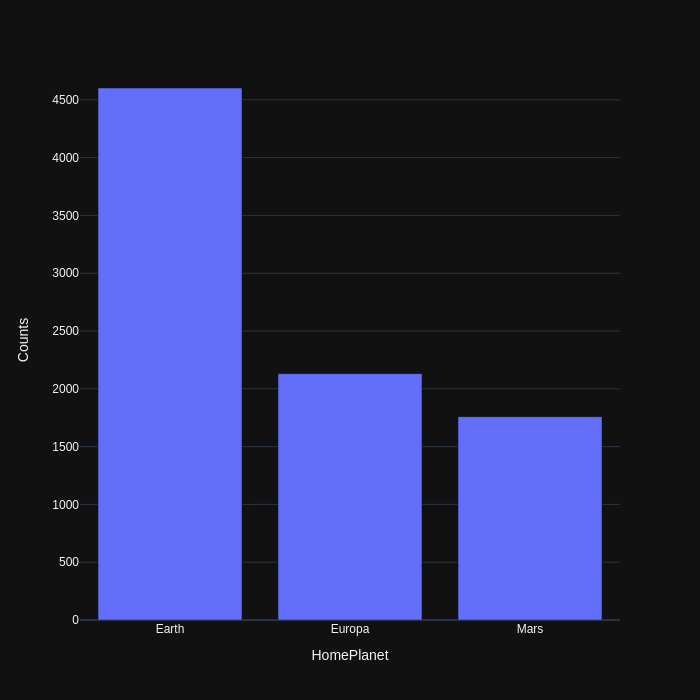

In [173]:
(
    px.bar(
        x=home_planet_counts.select("HomePlanet").to_series(),
        y=home_planet_counts.select("count").to_series()
    )
    .update_layout(showlegend=True,height=700)
    .update_yaxes(title="Counts")
    .update_xaxes(title="HomePlanet")
    .show("png")
)

In [178]:
# Available plots
list(_ for _ in dir(df_eager.plot) if not _.startswith("_"))

['area',
 'bar',
 'barh',
 'bivariate',
 'box',
 'dataset',
 'density',
 'errorbars',
 'explorer',
 'heatmap',
 'hexbin',
 'hist',
 'kde',
 'labels',
 'line',
 'ohlc',
 'paths',
 'points',
 'polygons',
 'scatter',
 'step',
 'table',
 'vectorfield',
 'violin']